In [92]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("11_Calculate_Disease_Enrichment")

from config import *
from helper_functions import zip_res_range, unzip_res_range, odds_ratio, fasta2dict, flatten

import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import os

import networkx as nx

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()

from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

This notebook calculates the similarity log odds ratios for enrichment of disease mutations on human interactors of SARS-CoV-2 and on specific interfaces (either with SARS-CoV-2 proteins or with other human proteins). A summary of the most enriched disease terms in the human interactor set is retained (MedGen_Term_Enrichments.txt).


- Inputs:
  - Interface_Summary.txt
  - Proteins.txt


- Static Resource Dependencies:
  - HGMD_201801_uniprotmapped.txt
    - **NOTE:** Database publically available without, a blank header describing the layout is provided instead
  - ClinVar2017_missense_uniprotmapped.txt
  - H_sapiens_interfacesALL.txt
  - keep_uniprot.fasta
  - MGREL.RRF
    - Downloaded on first run
  - MGCONSO.RRF
    - Downloaded on first run


- Outputs:
  - MedGen_Term_Enrichments.txt


- Dependencies:
  - Must be run after 08_Fetch_Top_Docks

# Parse Disease Mut Data from SARS2 Interactors

In [2]:
# Read in Protein into to get list of human interactors
proteins = pd.read_csv("{0}/Proteins.txt".format(output_dir), sep="\t")
uni2seq = proteins.set_index("ID")["Sequence"].to_dict()

# Parse HGDM

In [3]:
# Read in / subset HGMD dataset for only SARS2 interactors

# NOTE: This script originally runs using a parsed version of HGMD created in the Yu Lab. Because
#       HGMD requires users to register access their data (http://www.hgmd.cf.ac.uk/docs/register.html),
#       this dataset cannot be shared through this repository.
#
#       Additionally, an HDMD Professional license must be purchased to access the most up to date version
#       of the database (all data submitted in the past 3 years).
#       
#       For the purposes of this demo, a blank table including just the headers for this table are retained
#       in the input.

hgmd = pd.read_csv("{0}/HGMD_201801_uniprotmapped.txt".format(resource_dir), sep="\t")
hgmd_sub = hgmd[hgmd["UNIPROT_ACC"].isin(uni2seq.keys())]

In [4]:
print len(hgmd_sub)
hgmd_sub.head()

0


,ID,CLASS,DB,CHROM,POS_HG19,POS_HG38,REF,ALT,GENE,ENTREZ_GENE_ID,DNA,CODON_CHANGE,PROT,UNIPROT_ACC,AA_POS,AA_CHANGE,PHEN,PMID


In [5]:
# Approximate fraction of all human proteins with disease annotations
print len(hgmd["UNIPROT_ACC"].unique()) / 20000.0

# Fraction of SARS2 interactors with disease annotations
len(hgmd_sub["UNIPROT_ACC"].value_counts()) / float(len([x for x in uni2seq if not "COVID" in x]))

0.0


0.0

In [7]:
# Simple Odds Ratio for enrichment of general disease status
# in SARS2 interactor sub-set vs. whole proteome
n_proteome = 20350
n_interactors = len([x for x in uni2seq if not "COVID" in x])

a = len(hgmd_sub["UNIPROT_ACC"].unique())
b = n_interactors - len(hgmd_sub["UNIPROT_ACC"].unique())
c = len(hgmd["UNIPROT_ACC"].unique()) - len(hgmd_sub["UNIPROT_ACC"].unique())
d = n_proteome - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

             Case  Non-Case
Exposed       0.0      10.0
Non-Exposed   0.0   20340.0


(nan, nan, nan, nan)

In [8]:
# Map phenotype to number of genes associated with it for each
# the whole proteome and the subset containing SARS2 interactors
phen2genes_hgmd = defaultdict(int)
phen2genes_hgmd_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(hgmd.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        for real_phen in phen.split(";"):
            phen2genes_hgmd[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_hgmd_sub[real_phen] += 1

In [9]:
# Calculate Odds ratio per disease term
phen2OR_hgmd = dict()
for phen in tqdm_notebook(phen2genes_hgmd.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_hgmd_sub[phen]
    b = n_interactors - phen2genes_hgmd_sub[phen]
    c = phen2genes_hgmd[phen] - phen2genes_hgmd_sub[phen]
    d = n_proteome - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_hgmd[phen] = [OR, up, low, p, a, b, c, d]

In [10]:
# Concatenate summary for odds ratio from all disease terms
# Counts Column Interpretations...
# A - Has gene phenotype and is a SARS2 interactor
# B - No gene phenotype but is a SARS2 interactor
# C - Has gene phenotype but is not a SARS2 interactor
# D - No gene phenotype and not a SARS2 interactor
OR_summary_hgmd = pd.DataFrame([[k] + v for k, v in phen2OR_hgmd.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [11]:
# Check to see if there are any terms with perfect enrichment
# (all disease assocated genes are in interactome)
# Particularly is the A count is high
# NOTE: The odds ratio for this case can't be calculated, but
#       may be interesting, so we look at it separately
OR_summary_hgmd[OR_summary_hgmd["C"] == 0].sort_values("A", ascending=False)

,Phen,OR,Lower,Upper,p-value,A,B,C,D


In [12]:
# Look at significantly enriched terms
OR_summary_hgmd[(OR_summary_hgmd["p-value"] <= 0.05) & (OR_summary_hgmd["OR"] > 0)].sort_values("A", ascending=False)

,Phen,OR,Lower,Upper,p-value,A,B,C,D


# Parse ClinVar

In [13]:
# Read in / subset ClinVar dataset for only SARS2 interactors

# NOTE: This script runs using a parsed version of the ClinVar Database created in the Yu Lab.
#       The original downloading and parsing was performed by Siqi (Charles) Liang. Since the
#       ClinVar database is publically available (https://ftp.ncbi.nlm.nih.gov/pub/clinvar/)
#       the parsed version of the databse is provided.
#       
#       The enrichment results from this demo still aren't particularly informative because such
#       a small subset of interactions is selected for the demo. But the method of calculating the
#       enrichment should at least be clear.

clinvar = pd.read_csv("{0}/ClinVar2017_missense_uniprotmapped.txt".format(resource_dir), sep="\t")
clinvar_sub = clinvar[clinvar["UNIPROT_ACC"].map(lambda x: x in uni2seq.keys())]

In [14]:
# Approximate fraction of all human proteins with disease annotations
print len(clinvar["UNIPROT_ACC"].unique()) / 20000.0

# Fraction of SARS2 interactors with disease annotations
len(clinvar_sub["UNIPROT_ACC"].value_counts()) / float(len([x for x in uni2seq if not "COVID" in x]))

0.23735


0.3

In [16]:
# Simple Odds Ratio for enrichment of general disease status
# in SARS2 interactor sub-set vs. whole proteome
n_proteome = 20350
n_interactors = len([x for x in uni2seq if not "COVID" in x])

a = len(clinvar_sub["UNIPROT_ACC"].unique())
b = n_interactors - len(clinvar_sub["UNIPROT_ACC"].unique())
c = len(clinvar["UNIPROT_ACC"].unique()) - len(clinvar_sub["UNIPROT_ACC"].unique())
d = n_proteome - (a + b + c)

exposure_mask = np.zeros(a + b + c + d)
case_mask = np.zeros(a + b + c + d)
exposure_mask[:a+b] = 1
case_mask[:a] = 1
case_mask[a+b:a+b+c] = 1

odds_ratio(exposure_mask, case_mask, log_odds=True, verbose=True, two_sided=False)

               Case  Non-Case
Exposed         3.0       7.0
Non-Exposed  4744.0   15596.0


(0.49460772351518417,
 2.1326212146975201,
 -1.1434057676671521,
 0.30970978247789138)

In [17]:
# Map phenotype to number of genes associated with it for each
# the whole proteome and the subset containing SARS2 interactors
phen2genes_clinvar = defaultdict(int)
phen2genes_clinvar_sub = defaultdict(int)
keep_unis = set(uni2seq.keys())
for g in tqdm_notebook(clinvar.drop_duplicates(["UNIPROT_ACC", "PHEN"]).groupby("UNIPROT_ACC")):
    for phen in g[1]["PHEN"]:
        phen = str(phen)
        for real_phen in phen.split(";"):
            phen2genes_clinvar[real_phen] += 1
            if(g[0] in keep_unis):
                phen2genes_clinvar_sub[real_phen] += 1

In [19]:
# Calculate Odds ratio per disease term
phen2OR_clinvar = dict()
for phen in tqdm_notebook(phen2genes_clinvar.keys()):
    # Case = Gene has phenotype vs. Gene does not have phenotype
    # Exposure = Gene in interactome vs. Gene no in interactome
    a = phen2genes_clinvar_sub[phen]
    b = n_interactors - phen2genes_clinvar_sub[phen]
    c = phen2genes_clinvar[phen] - phen2genes_clinvar_sub[phen]
    d = n_proteome - (a + b + c)
    
    #if(0 in [a, b, c, d]):
    #    continue
    
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[(a+b):(a+b+c)] = 1
    
    OR, up, low, p = odds_ratio(exposure_mask, case_mask, log_odds=True)
    
    phen2OR_clinvar[phen] = [OR, up, low, p, a, b, c, d]

In [20]:
# Concatenate summary for odds ratio from all disease terms
# Counts Column Interpretations...
# A - Has gene phenotype and is a SARS2 interactor
# B - No gene phenotype but is a SARS2 interactor
# C - Has gene phenotype but is not a SARS2 interactor
# D - No gene phenotype and not a SARS2 interactor
OR_summary_clinvar = pd.DataFrame([[k] + v for k, v in phen2OR_clinvar.iteritems()], columns=["Phen", "OR", "Lower", "Upper", "p-value", "A", "B", "C", "D"])

In [21]:
# Check to see if there are any terms with perfect enrichment
# (all disease assocated genes are in interactome)
# Particularly is the A count is high
# NOTE: The odds ratio for this case can't be calculated, but
#       may be interesting, so we look at it separately
OR_summary_clinvar[OR_summary_clinvar["C"] == 0].sort_values("A", ascending=False)

,Phen,OR,Lower,Upper,p-value,A,B,C,D
9,"Impdh2 enzyme activity, variation in",NaN,NaN,NaN,NaN,1,9,0,20340
566,Hyperphosphatasia with mental retardation synd...,NaN,NaN,NaN,NaN,1,9,0,20340
3439,nicotine response - Efficacy,NaN,NaN,NaN,NaN,1,9,0,20340


In [22]:
# Look at significantly enriched terms
OR_summary_clinvar[(OR_summary_clinvar["p-value"] <= 0.05) & (OR_summary_clinvar["OR"] > 0)].sort_values("A", ascending=False)

,Phen,OR,Lower,Upper,p-value,A,B,C,D
4982,Hyperphosphatasia with Intellectual Disability...,11.311890,14.311111,8.312670,1.443290e-13,2,8,2,20338
2667,nan,3.613368,6.601339,0.625398,1.777873e-02,1,9,183,20157


# Calculate Disease Enrichment at Interfaces

In [23]:
# Set up masks to use for calculating enrichment

# Mask for interface residues based on viral interfaces
uni2ires_mask_viral = dict()

# Mask for interface residues based on other human-human interfaces
uni2ires_mask_insider = dict()

# Mask for locations of HGMD disease variants
uni2hgmd_mask = dict()

# Mask for locations of CLinVar disease variants
uni2clinvar_mask = dict()

In [24]:
# Read in viral interface info
ires_df = pd.read_csv("{0}/Interface_Summary.txt".format(output_dir), sep="\t")
ires_df = ires_df.sort_values(["P1", "P2", "Source"]).drop_duplicates(["P1", "P2"])
#ires_df = ires_df[ires_df["Source"] == "ECLAIR"]
#ires_df = ires_df[ires_df["Source"] == "Docking"]

In [25]:
# Populate Ires Viral Masks
for p2, p2_ires in tqdm_notebook(ires_df[["P2", "P2_Ires"]].values):
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not p2 in uni2ires_mask_viral):
        uni2ires_mask_viral[p2] = np.zeros(len(uni2seq[p2]))
    
    if(not pd.isnull(p2_ires)):
        # Parse interface positions
        p2_ires = [int(x)-1 for x in p2_ires.split(",")]
        
        # Update Mask
        uni2ires_mask_viral[p2][p2_ires] = 1

In [26]:
# Read in INSIDER human-human interface annotations
insider = pd.read_csv("{0}/H_sapiens_interfacesALL.txt".format(resource_dir), sep="\t")

# Uncomment if only co-crystal structures / homology models are desired
#insider = insider[insider["Source"] != "ECLAIR"]

In [27]:
# Select relevant list of human UniProts
# 1. Anything in the SARS2-human interactome
# 2. Anything with a disease annotation
# 3. Anything with reported human-human interactions in INSIDER
keep_unis = set(ires_df["P2"].unique())
print len(keep_unis)
keep_unis.update(hgmd["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(clinvar["UNIPROT_ACC"].unique())
print len(keep_unis)
keep_unis.update(insider["P1"].to_list() + insider["P2"].to_list())
print len(keep_unis)

10
10
4754
16068


In [28]:
## Read in sequence information fo these UniProts
##
## NOTE: Originally parsed from uniprot_all.fasta, but this takes
##       a long time to parse, so I've just saved the relevant sub-set
##       and read in from that fasta.
##       
##       Original uniprot_all.fasta file not provided, but is a combination
##       of the sprot and trembl fastas available through the UniProt FTP servers
##
##       - https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
##       - https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_trembl.fasta.gz
#uniall2seq = fasta2dict("{0}/uniprot_all.fasta".format(resource_dir), key_transform=lambda x: x.split("|")[1], keep=keep_unis)
#
## Save so don't need to parse uniprot_all again
#dict2fasta("../keep_uniprot.fasta", uniall2seq)

In [37]:
# Read in sequence information fo these UniProts
uniall2seq = fasta2dict("{0}/keep_uniprot.fasta".format(resource_dir))

In [39]:
# Flag any cases where there are discrepencies in the sequences
# for these UniProts
# (should not happen, but if it does, stick to the seqeunce that
#  was used in the rest of this project over the one fetched from
#  uniprot_all.fasta)
for k in uni2seq:
    if(k in uniall2seq):
        if(not uni2seq[k] == uniall2seq[k]):
            print k
            uniall2seq[k] = uni2seq[k]

In [40]:
# Populate Ires Human Masks
missing = set()
wrong_length = set()

# Iterate over all interfaces from P1
for p1, p1_ires in tqdm_notebook(insider[["P1", "P1_IRES"]].values):
    try:
        # If no mask exists for this protein, initialize an all-zeros mask
        if(not p1 in uni2ires_mask_insider):
            uni2ires_mask_insider[p1] = np.zeros(len(uniall2seq[p1]))
        
        
        if(not pd.isnull(p1_ires)):
            # Parse interface positions
            p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires)]
            # Automatically drop any interfaces not in range
            # NOTE: Decided this is not a safe way to do it. If there are any
            #       interfaces out of range, then the whole sequence could be
            #       misalinged compared to the sequence used in defining the
            #       interface residues in INSIDER. We should just drop these
            #       cases to be safe.
            #
            # NOTE: Does not catch cases where the new sequence is longer than
            #       the sequence used from INSIDER
            #p1_ires = [int(x)-1 for x in unzip_res_range(p1_ires) if int(x)-1 < len(uniall2seq[p1])]
            
            # Try to update the mask
            try:
                uni2ires_mask_insider[p1][p1_ires] = 1
            # If any of the interfaces listed in INSIDER are out of range
            # based on the length of the current available UniProt sequence then
            # we're looking at some odd case (most likely the UniProt sequence
            # has changed (different isoform?) between original INSIDER construction
            # and now)
            except IndexError:
                wrong_length.add(p1)
                continue
    
    # If we didn't get a sequence for this protein from our uniprot_all parsing
    # just ignore it and move on
    except KeyError:
        missing.add(p1)

# Iterate over all interfaces from P2
for p2, p2_ires in tqdm_notebook(insider[["P2", "P2_IRES"]].values):
    try:
        # If no mask exists for this protein, initialize an all-zeros mask
        if(not p2 in uni2ires_mask_insider):
            uni2ires_mask_insider[p2] = np.zeros(len(uniall2seq[p2]))
        
        
        if(not pd.isnull(p2_ires)):
            # Parse interface positions
            p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires)]
            # Automatically drop any interfaces not in range
            # NOTE: Decided this is not a safe way to do it. If there are any
            #       interfaces out of range, then the whole sequence could be
            #       misalinged compared to the sequence used in defining the
            #       interface residues in INSIDER. We should just drop these
            #       cases to be safe.
            #
            # NOTE: Does not catch cases where the new sequence is longer than
            #       the sequence used from INSIDER
            #p2_ires = [int(x)-1 for x in unzip_res_range(p2_ires) if int(x)-1 < len(uniall2seq[p2])]
            
            # Try to update the mask
            try:
                uni2ires_mask_insider[p2][p2_ires] = 1
            # If any of the interfaces listed in INSIDER are out of range
            # based on the length of the current available UniProt sequence then
            # we're looking at some odd case (most likely the UniProt sequence
            # has changed (different isoform?) between original INSIDER construction
            # and now)
            except IndexError:
                wrong_length.add(p2)
                continue
    
    # If we didn't get a sequence for this protein from our uniprot_all parsing
    # just ignore it and move on
    except KeyError:
        missing.add(p2)

In [41]:
# Number of UniProts with discrepencies in length / interface annotation
print len(wrong_length)

# Number of UniProts with sequence unavailable
print len(missing)

26
38


In [42]:
# Populate HGMD Mask
c1 = 0 # Number of mutations skipped for data discrepencies
c2 = 0 # Number of mutations counted

# Iterate over all disease muts
for uni, pos, aa_change in tqdm_notebook(hgmd[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    # If sequence for this Uniprot not available just ignore
    if not uni in uniall2seq:
        continue
    
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not uni in uni2hgmd_mask):
        uni2hgmd_mask[uni] = np.zeros(len(uniall2seq[uni]))
    
    # If the position of the disease mutant is outside of the range
    # expected based on the protein sequence length or there is a
    # discrepency in the reference allele at the mutant position between
    # HGMD and our UniProt sequence, then skip it (can't trust the
    # data)
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2hgmd_mask[uni][pos-1] = 1

In [44]:
# Mutations with Discrepencies
print c1

# Total Mutations
print c2

# Discrepency Rate
try:
    print c1 / float(c2)
except ZeroDivisionError:
    print "No Mutations"

0
0
No Mutations


In [45]:
# Populate ClinVar Mask
c1 = 0
c2 = 0

# Iterate over all disease muts
for uni, pos, aa_change in tqdm_notebook(clinvar[["UNIPROT_ACC", "AA_POS","AA_CHANGE" ]].values):
    # If sequence for this Uniprot not available just ignore
    if not uni in uniall2seq:
        continue
    
    # If no mask exists for this protein, initialize an all-zeros mask
    if(not uni in uni2clinvar_mask):
        uni2clinvar_mask[uni] = np.zeros(len(uniall2seq[uni]))
    
    # If the position of the disease mutant is outside of the range
    # expected based on the protein sequence length or there is a
    # discrepency in the reference allele at the mutant position between
    # HGMD and our UniProt sequence, then skip it (can't trust the
    # data)
    if(pos > len(uniall2seq[uni]) or uniall2seq[uni][pos-1] != aa_change[0]):
        c1 += 1
        continue
    c2 += 1
    uni2clinvar_mask[uni][pos-1] = 1

In [46]:
# Mutations with Discrepencies
print c1

# Total Mutations
print c2

# Discrepency Rate
print c1 / float(c2)

1169
113202
0.0103266726736


In [47]:
# Calculate Odds Ratios per protein
# for enrichment of either ClinVar or HGMD mutations
# in either human-viral or human-human interfaces
summary = []

# Separate masks to store aggregate data
# for full proteome vs. only SARS2 interactors
insider_hgmd_masks = [[], []]
insider_clinvar_masks = [[], []]
insider_hgmd_masks_all = [[], []]
insider_clinvar_masks_all = [[], []]
viral_hgmd_masks = [[], []]
viral_clinvar_masks = [[], []]

for uni in tqdm_notebook(keep_unis):
    if(not uni in uniall2seq):
        continue
    try:
        m_ires_v = uni2ires_mask_viral[uni]
    except KeyError:
        m_ires_v = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_ires_h = uni2ires_mask_insider[uni]    
    except KeyError:
        m_ires_h = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_hgmd = uni2hgmd_mask[uni]
    except KeyError:
        m_hgmd = np.zeros(len(uniall2seq[uni]))
    
    try:
        m_clinvar = uni2clinvar_mask[uni]
    except KeyError:
        m_clinvar = np.zeros(len(uniall2seq[uni]))
        
    tmp = [uni, sum(m_ires_v), sum(m_ires_h), sum(m_hgmd), sum(m_clinvar)]
    if(tmp[1:] == [0, 0, 0, 0]):
        continue
    
    mask1 = m_ires_v
    mask2 = m_hgmd
    tmp += odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "A"
        viral_hgmd_masks[0].append(mask1)
        viral_hgmd_masks[1].append(mask2)
    
    mask1 = m_ires_v
    mask2 = m_clinvar
    tmp += odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        #print uni, "B"
        viral_clinvar_masks[0].append(mask1)
        viral_clinvar_masks[1].append(mask2)
    
    mask1 = m_ires_h
    mask2 = m_hgmd
    tmp += odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_hgmd_masks[0].append(mask1)
            insider_hgmd_masks[1].append(mask2)
        insider_hgmd_masks_all[0].append(mask1)
        insider_hgmd_masks_all[1].append(mask2)

    
    mask1 = m_ires_h
    mask2 = m_clinvar
    tmp += odds_ratio(mask1, mask2, log_odds=True)
    if(sum(mask1) > 0 and sum(mask2) > 0):
        if(uni in uni2seq):
            insider_clinvar_masks[0].append(mask1)
            insider_clinvar_masks[1].append(mask2)
        insider_clinvar_masks_all[0].append(mask1)
        insider_clinvar_masks_all[1].append(mask2)

    
    summary.append(tmp)

# We don't really case about the per-protein analysis
# on this one, but the setup here is...
#
# OR_X:Y
#
# where X can be either H (human-human interfaces from INSIDER)
# or V (viral interfaces defined here)
#
# and Y can be either H (HGMD) or C (ClinVar)
summary = pd.DataFrame(summary, columns=["UniProt", "n_Ires_Viral", "n_Ires_Human", "n_HGMD", "n_Clinvar", "OR_V:H", "Up_V:H", "Low_V:H", "p_V:H", "OR_V:C", "Up_V:C", "Low_V:C", "p_V:C", "OR_H:H", "Up_H:H", "Low_H:H", "p_H:H", "OR_H:C", "Up_H:C", "Low_H:C", "p_H:C"])

In [51]:
# View Enrichment within these different categories
labels = ["Human Interface (Proteome) HGMD Muts", "Human Interface (SARS2 Interactors) HGMD Muts", "Viral Interface HGMD Muts", "Human Interface (Proteome) ClinVar Muts", "Human Interface (SARS2 Interactors) ClinVar Muts", "Viral Interface ClinVar Muts"]
masks = [insider_hgmd_masks_all, insider_hgmd_masks, viral_hgmd_masks, insider_clinvar_masks_all, insider_clinvar_masks, viral_clinvar_masks]
for m_set, l in zip(masks, labels):
    # Skip HGMD since the data is not provided
    if("HGMD" in l):
        continue
    print l
    mask1 = np.concatenate(m_set[0])
    mask2 = np.concatenate(m_set[1])
    print odds_ratio(mask1, mask2, verbose=True, log_odds=True, error="SE")
    print

Human Interface (Proteome) ClinVar Muts
                Case   Non-Case
Exposed      16432.0   412043.0
Non-Exposed  71853.0  2557905.0
(0.50555557020453712, 0.51826374371010664, 0.49284739669896782, 0.0)

Human Interface (SARS2 Interactors) ClinVar Muts
             Case  Non-Case
Exposed       0.0     335.0
Non-Exposed   3.0     447.0
(nan, nan, nan, nan)

Viral Interface ClinVar Muts
             Case  Non-Case
Exposed       0.0      54.0
Non-Exposed   3.0     728.0
(nan, nan, nan, nan)



In [52]:
# Human Interactors with Enrichment of Disease Mutations
# by HGMD in their human-viral Interfaces
summary[summary["p_V:H"] <= 0.05].sort_values("OR_V:H")

,UniProt,n_Ires_Viral,n_Ires_Human,n_HGMD,n_Clinvar,OR_V:H,Up_V:H,Low_V:H,p_V:H,OR_V:C,Up_V:C,Low_V:C,p_V:C,OR_H:H,Up_H:H,Low_H:H,p_H:H,OR_H:C,Up_H:C,Low_H:C,p_H:C


In [53]:
# Human Interactors with Enrichment of Disease Mutations
# by ClinVar in their human-viral Interfaces
summary[summary["p_V:C"] <= 0.05].sort_values("OR_V:C")

,UniProt,n_Ires_Viral,n_Ires_Human,n_HGMD,n_Clinvar,OR_V:H,Up_V:H,Low_V:H,p_V:H,OR_V:C,Up_V:C,Low_V:C,p_V:C,OR_H:H,Up_H:H,Low_H:H,p_H:H,OR_H:C,Up_H:C,Low_H:C,p_H:C


In [54]:
# Human Interactors with Enrichment of Disease Mutations
# by HGMD in their human-human Interfaces
summary[summary["p_H:H"] <= 0.05].sort_values("OR_H:H")

,UniProt,n_Ires_Viral,n_Ires_Human,n_HGMD,n_Clinvar,OR_V:H,Up_V:H,Low_V:H,p_V:H,OR_V:C,Up_V:C,Low_V:C,p_V:C,OR_H:H,Up_H:H,Low_H:H,p_H:H,OR_H:C,Up_H:C,Low_H:C,p_H:C


In [55]:
# Human Interactors with Enrichment of Disease Mutations
# by ClinVar in their human-human Interfaces
summary[summary["p_H:C"] <= 0.05].sort_values("OR_H:C")

,UniProt,n_Ires_Viral,n_Ires_Human,n_HGMD,n_Clinvar,OR_V:H,Up_V:H,Low_V:H,p_V:H,OR_V:C,Up_V:C,Low_V:C,p_V:C,OR_H:H,Up_H:H,Low_H:H,p_H:H,OR_H:C,Up_H:C,Low_H:C,p_H:C
1382,P61769,0.0,101.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.643856,-0.098026,-7.189687,0.043994
6455,P47897,0.0,311.0,0.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.942992,-0.844149,-5.041835,0.005991
14037,P05093,0.0,204.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.668265,-0.544712,-4.791818,0.013789
3519,P24752,0.0,162.0,0.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.464886,-0.713148,-4.216624,0.005818
11411,Q13496,0.0,156.0,0.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.353796,-0.862948,-3.844644,0.001972
4420,P40939,0.0,240.0,0.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.165465,-0.051696,-4.279235,0.044654
86,P29400,0.0,86.0,0.0,225.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.157180,-0.482869,-3.831491,0.011563
9743,P16930,0.0,119.0,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.138561,-0.023028,-4.254094,0.047558
6724,P61244,0.0,80.0,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.882278,-0.197508,-3.567048,0.028544
1457,Q9UMX1,0.0,162.0,0.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.854097,-0.313737,-3.394458,0.018316


# Analyze Term Enrichment Based on Disease Ontology DAG

In [56]:
# The goal here is to re-do the enrichment calculations looking at disease terms
# in the context of a full disease ontology. Where for instance, a particular variant
# may only be listed under a specific phenotype "Colorectal Cancer" but could also
# apply to a more general "Cancer" term.
#
# In this way, when we count a term, we also add that count to all its parents so that
# we can accurately look at enrichment at all levels of specificity. This avoids running
# into issues where we have low counts (can't do good statistical analysis) from many specific
# terms, and could instead do a good enrichment test on a more general common parent term.

In [58]:
# Download and Read in Raw MedGen Relationships (these files too large to include in repository)
if(not os.path.exists("{0}/MGREL.RRF".format(resource_dir))):
    os.system("wget https://ftp.ncbi.nlm.nih.gov/pub/medgen/MGREL.RRF.gz --directory-prefix {0}".format(resource_dir))
    os.system("gunzip {0}/MGREL.RRF.gz".format(resource_dir))
medgen_rel = pd.read_csv("{0}/MGREL.RRF".format(resource_dir), sep="|")
medgen_rel.head()

,#CUI1,AUI1,STYPE1,REL,CUI2,AUI2,RELA,RUI,SAB,SL,SUPPRESS,Unnamed: 11
0,C0000727,A0017734,AUI,SY,C0000727,A0017736,permuted_term_of,R28483132,MSH,MSH,N,NaN
1,C0000727,A0017734,AUI,SY,C0000727,A0019566,permuted_term_of,R28483133,MSH,MSH,N,NaN
2,C0000727,A0017734,AUI,SY,C0000727,A0019567,permuted_term_of,R28483134,MSH,MSH,N,NaN
3,C0000727,A0017734,SDUI,PAR,C0000737,A0017753,NaN,R71382266,MSH,MSH,N,NaN
4,C0000727,A0017734,SDUI,AQ,C0007994,A3879713,NaN,R120176394,MSH,MSH,N,NaN


In [59]:
# Total Number of Terms
all_terms = set(medgen_rel["#CUI1"].to_list() + medgen_rel["CUI2"].to_list())
print len(all_terms)

# Only Terms involved in Parent / Child Relationships
child_parent_terms = set(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["#CUI1"].to_list() + medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])]["CUI2"].to_list())
print len(child_parent_terms)

102120
62838


In [70]:
# NOTE: Only the ClinVar dataset lists MedGen terms, so we
#       only work with this dataset here

# Subset of MedGen Terms from ClinVar
clinvar_terms = set(flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
print len(clinvar_terms)

# Overlap with Parent / Child Terms
print len(clinvar_terms.intersection(child_parent_terms))

# Overlap with All Terms from MedGen Relationships
# I'm unsure what's up with the ~1500 that are missing
# from the MedGen REL file (maybe they just aren't in any
# relationships?)
print len(clinvar_terms.intersection(all_terms))

6275
2945
4712


In [73]:
# Here we being constructing a directed graph for the disease ontology
# We first add in all the parent child relationships listed in the MedGene
# relationships.
#
dag = nx.DiGraph()

# Add all the Nodes.
# Each node stores the counts that will be used for its enrichment
# We start these as out with no disease gene counts (e.g. everything
# is either an interacotr non-disease gene (b) or a non-interactor
# non-disease gene (d)). As we parse the graph we will update these
# counts by adding / subtracting as necessary and propogating the
# changed through to the parent nodes
for c1, c2 in tqdm_notebook(medgen_rel[["#CUI1", "CUI2"]].values):
    dag.add_node(c1, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})
    dag.add_node(c2, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})

# Add all the relationships
for c1, c2, rel in tqdm_notebook(medgen_rel[medgen_rel["REL"].isin(["PAR", "CHD"])][["#CUI1", "CUI2", "REL"]].values):
    if(rel == "PAR"):
        dag.add_edge(c2, c1)
    else:
        dag.add_edge(c1, c2)

# Add in any extra terms from ClinVar Table with no relationships
for c in set(flatten(clinvar["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list())):
    dag.add_node(c, **{"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False})

In [74]:
# Updates the counts for a node and its predecessors
def propogate_updates(g, n, is_interactor):
    # If the node doesn't exist, initialize it
    if(not n in g.nodes):
        g.add_node(n, **{"a":0, "b":322, "c":0, "d":20350-332, "block":False})
    #print n
    
    # If the node has been blocked (i.e. has already been visited
    # in this round of updates, then stop)
    if(g.node[n]["block"]):
        #print "Already Reached", n
        return
    
    # Otherwise, update the count as necessary depending on if this gene
    # is / is not an interactor of SARS2
    else:
        if(is_interactor):
            g.node[n]["a"] += 1
            g.node[n]["b"] -= 1
        else:
            g.node[n]["c"] += 1
            g.node[n]["d"] -= 1
        
        # Block this node so that it is not revisited
        g.node[n]["block"] = True
        
        # Propogate the update through all parent terms
        for p in g.predecessors(n):
            propogate_updates(g, p, is_interactor)
# FUNCTION END

# Unblocks all the nodes in the network
def unblock_all(g):
    for n in g.nodes:
        g.node[n]["block"] = False
# FUNCTION END

# Resets all the nodes in the network to their initial conditions
def reset_all(g):
    for n in g.nodes:
        for k, v in {"a":0, "b":n_interactors, "c":0, "d":n_proteome-n_interactors, "block":False}.iteritems():
            g.node[n][k] = v
# FUNCTION END

In [75]:
# Make sure the network is reinitialized with starting counts
reset_all(dag)

In [76]:
# Iterate through all Uniprot IDs in the ClinVar Data
for uni, g in tqdm_notebook(clinvar[["UNIPROT_ACC", "PHEN_IDS", "PHEN"]].groupby("UNIPROT_ACC")):
    # Fetch all the MedGen terms associated with this gene
    med_gen_terms = set(flatten(g["PHEN_IDS"].map(lambda x: [y.split(":")[1] for y in str(x).replace(";", ",").split(",") if y.split(":")[0] == "MedGen"]).to_list()))
    
    # Figure out if this is an interactor
    is_interactor = uni in uni2seq.keys()
    
    # Udate the gene counts for all terms
    # this gene is invovled in and its parents
    for n in med_gen_terms:
        propogate_updates(dag, n, is_interactor)
    
    # Unblock all nodes in the network to prepare for adding the next gene
    unblock_all(dag)

In [77]:
# Store initial summary reporting each term, the counts, and its
# list of immediate children and parents.
summary = []
for n in tqdm_notebook(dag.nodes):
    summary.append([n, dag.nodes[n]["a"], dag.nodes[n]["b"], dag.nodes[n]["c"], dag.nodes[n]["d"], ",".join(dag.successors(n)), ",".join(dag.predecessors(n))])
summary = pd.DataFrame(summary, columns=["ID", "A", "B", "C", "D", "Children", "Parents"])

# Save this summary
summary.to_csv("{0}/MedGen_Term_Enrichments.txt".format(output_dir), sep="\t", index=None)

In [81]:
# Only retain information for the terms that have at least
# one gene associated with them
summary = summary[(summary["A"] != 0)|(summary["C"] != 0)]

# Calculate Odds Ratio for enrichment of SARS2 interactors
# within each disease term
def do(a, b, c, d):
    if([0] in [a, b, c, d]):
        return np.nan, np.nan, np.nan, np.nan
    exposure_mask = np.zeros(a + b + c + d)
    case_mask = np.zeros(a + b + c + d)
    exposure_mask[:a+b] = 1
    case_mask[:a] = 1
    case_mask[a+b:a+b+c] = 1

    OR, up, low, p = odds_ratio(exposure_mask, case_mask, log_odds=True, two_sided=False)
    pbar.update()
    return OR, low, up, p
# FUNCTION END

# Calculate OR / Format the results into new columns
pbar = tqdm_notebook(total=len(summary))
tmp = summary[["A", "B", "C", "D"]].apply(lambda x: do(*x), axis=1)
summary["LogOR"] = [x[0] for x in tmp]
summary["Low"] = [x[1] for x in tmp]
summary["Up"] = [x[2] for x in tmp]
summary["p-value"] = [x[3] for x in tmp]

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [82]:
# Number of significnatly enriched terms
print len(summary[summary["p-value"] <= 0.05])

2


In [83]:
# Download and Read in Raw MedGen Term Descriptions to get named for each term
# NOTE: these files too large to include in repository
if(not os.path.exists("{0}/MGCONSO.RRF".format(resource_dir))):
    os.system("wget https://ftp.ncbi.nlm.nih.gov/pub/medgen/MGCONSO.RRF.gz --directory-prefix {0}".format(resource_dir))
    os.system("gunzip {0}/MGREL.RRF.gz".format(resource_dir))
medgen_names = pd.read_csv("{0}/MGCONSO.RRF".format(resource_dir), sep="|")
medgen_names.head()

,#CUI,TS,STT,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SUPPRESS,Unnamed: 13
0,C0000005,P,PF,Y,A26634265,NaN,M0019694,D012711,MSH,PEP,D012711,(131)I-Macroaggregated Albumin,N,NaN
1,C0000005,S,PF,Y,A26634266,NaN,M0019694,D012711,MSH,ET,D012711,(131)I-MAA,N,NaN
2,C0000039,P,VC,Y,A0016515,NaN,M0023172,D015060,MSH,MH,D015060,"1,2-Dipalmitoylphosphatidylcholine",N,NaN
3,C0000039,S,VW,Y,A0100864,NaN,M0023172,D015060,MSH,PM,D015060,"Phosphatidylcholine, Dipalmitoyl",N,NaN
4,C0000039,S,PF,Y,A0528280,NaN,M0023172,D015060,MSH,N1,D015060,"3,5,9-Trioxa-4-phosphapentacosan-1-aminium, 4-...",N,NaN


9179/|/100%|| 9179/9179 [01:50<00:00, 96.10it/s]

In [84]:
# Create term --> name mapping
term2name = defaultdict(str)
term2name.update(medgen_names[(medgen_names["TS"] == "P")&(medgen_names["STT"] == "PF")].drop_duplicates("#CUI")[["#CUI", "STR"]].set_index("#CUI")["STR"].to_dict())

In [85]:
# Update Summary with correct Name
summary["Name"] = summary["ID"].map(lambda x: term2name[x])

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [86]:
# Add Enrichment information / name back into the network
for id, a, b, c, d, OR, low, up, p, name in summary[["ID", "A", "B", "C", "D", "LogOR", "Low", "Up", "p-value", "Name"]].values:
    dag.node[id]["OR"] = OR
    dag.node[id]["low"] = low
    dag.node[id]["up"] = up
    dag.node[id]["p"] = p
    dag.node[id]["name"] = name

In [87]:
# Function to add a node and its ancestors from the original dag to a new graph g
def add_node_plus_acnestors(g, n, nodes=set(), edges=set()):
    # If the node is already in the set of nodes stop
    if(n in nodes):
        return
    
    # Add the node to the graph and add it to the list of nodes
    g.add_node(n, **dag.node[n])
    nodes.add(n)
    
    # If there are no ancestor nodes for this node,
    # add connect it to a universal root node
    if(len(list(dag.predecessors(n))) == 0):
        g.add_edge("root", n)
        edges.add(("root", n))
    
    # Otherwise add all the ancestors
    for p in dag.predecessors(n):
        if(not (p, n) in edges):
            g.add_edge(p, n)
            edges.add((p, n))
        
        add_node_plus_acnestors(g, p, nodes, edges)
    
    return
# FUNCTION END

In [88]:
# Create a sub-set for the term network containing only significant terms and their
# ancestors
sub_dag = nx.DiGraph()
sub_dag.add_node("root", **{"name":"root"})
nodes = set("root")
edges = set()
for n in tqdm_notebook(summary[summary["p-value"] <= 0.05].sort_values("A", ascending=False)["ID"]):
    add_node_plus_acnestors(sub_dag, n, nodes, edges)

In [89]:
len(sub_dag.nodes)

3

In [90]:
len(edges)

2

In [103]:
colors

['#EEEEEE', (0.5, 0.0, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]

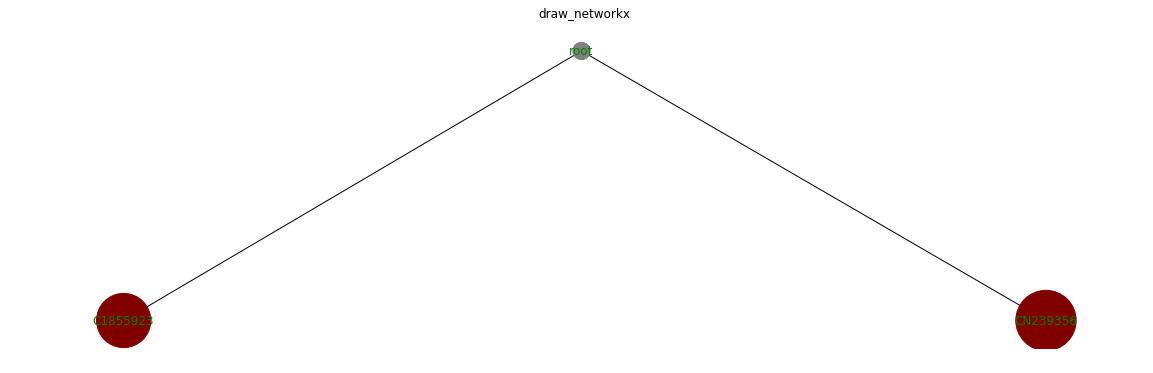

In [109]:
# Attempt to plot the sub-network of significant genes
#
# Can't be meaningfully viewed from here, but the svg can be saved
# and inspected

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

# same layout using matplotlib with no labels
#plt.figure(figsize=(200*3, 60*3))
plt.figure(figsize=(20, 6))
plt.title('draw_networkx')
pos = graphviz_layout(sub_dag, prog='dot')


# Add color based on level of significance
vmax = 10
cmap = lambda x: matplotlib.cm.seismic(1 - (float((np.log(x) - np.log(0.05) + vmax)) / (vmax*2.0)))
colors = []

# Add size based on Odds Ratio
sizes = []

# Add label from term name
labels = dict()
for n in sub_dag.nodes:
    if("p" in sub_dag.node[n]):
        colors.append(cmap(sub_dag.node[n]["p"]))
        sizes.append(300 + 300*abs(sub_dag.node[n]["OR"]))
        labels[n] = "{0} ({1})\nOR: {2:0.2f} ({3:0.2f}={4:0.2f})\np: {5}\n{6}\t{7}\n{8}\t{9}".format(n, sub_dag.node[n]["name"], sub_dag.node[n]["OR"], sub_dag.node[n]["low"], sub_dag.node[n]["up"], sub_dag.node[n]["p"], sub_dag.node[n]["a"], sub_dag.node[n]["b"], sub_dag.node[n]["c"], sub_dag.node[n]["d"])
    else:
        colors.append((0.5, 0.5, 0.5, 1))
        sizes.append(300)
        labels[n] = n

nx.draw(sub_dag, pos, labels=None, arrows=False, node_color=colors, node_size=sizes, font_color="g")

In [110]:
# Add list of significant parent / child terms to the summary
# This way we can select to view the results based on only the most
# specific or most general term (while retaining significance)
summary["Significant Parents"] = summary["Parents"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))
summary["Significant Children"] = summary["Children"].map(lambda x: ",".join([y for y in x.split(",") if y in dag.nodes and "p" in dag.node[y] and dag.node[y]["p"] <= 0.05]))

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [111]:
# Add lists of all Significant Ancestors / Descendents relative to
# the given node
def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.predecessors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Ancestors"] = tmp

def do(n, sig=set(), seen=set(), first=True):
    if(n in seen):
        return sig, seen
    seen.add(n)
    if(not first and "p" in dag.node[n] and dag.node[n]["p"] <= 0.05):
        sig.add(n)
    
    for p in dag.successors(n):
        tmp_sig, tmp_seen = do(p, sig=sig, seen=seen, first=False)
        sig.update(tmp_sig)
        seen.update(seen)
    
    if(first):
        pbar.update()
        return ",".join(sig)
    return sig, seen
# FUNCTION END
pbar = tqdm_notebook(total=len(summary))
tmp = [do(x, sig=set(), seen=set(), first=True) for x in summary["ID"].to_list()]
summary["Significant Descendants"] = tmp

/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/home/sdw95/.conda/envs/jp/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
# Save the updated Term Enrichments Summary
summary.to_csv("{0}/MedGen_Term_Enrichments.txt".format(resource_dir), sep="\t", index=None)

In [114]:
# All significant nodes.
# Also filtered so that we only so the most general term possible what is still significant
# i.e. from any significant node, we continue to go up the network until significance is lost
# at the next parent
summary[(summary["p-value"] <= 0.05)&(summary["Significant Ancestors"] == "")&(summary["A"] >= 1)].sort_values("LogOR", ascending=False)[["Name", "ID", "A", "B", "C", "D", "LogOR", "p-value"]]

,Name,ID,A,B,C,D,LogOR,p-value
13568,,CN239356,1,9,1,20339,11.142036,5.323501e-08
75587,Hyperphosphatasia-intellectual disability synd...,C1855923,1,9,5,20335,8.819824,4.673799e-08
